In [112]:
import pandas
import numpy
import matplotlib.pyplot as plt
import sklearn as skl
import scipy.stats

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [113]:
test = pandas.read_csv("data/nba_teste.csv")
train = pandas.read_csv("data/nba_treino.csv")

In [114]:
train_X = train.drop(['TARGET_5Yrs'], axis=1)
test_X = test.drop(['TARGET_5Yrs'], axis=1)

train_y = train['TARGET_5Yrs']
test_y = test['TARGET_5Yrs']

In [115]:
test

,GP,MIN,PTS,FGM,FGA,FG%,3PMade,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,40,6.7,3.6,1.2,3.0,39.8,0.1,0.6,13.6,1.1,1.5,77.6,0.5,0.8,1.2,0.4,0.3,0.1,0.6,1
1,27,6.6,1.3,0.6,1.3,47.2,0.0,0.0,0.0,0.1,0.3,28.6,0.6,1.4,2.0,0.2,0.2,0.6,0.3,1
2,44,6.4,2.4,1.0,1.9,53.7,0.0,0.0,0.0,0.4,0.7,50.0,0.4,1.0,1.4,0.2,0.2,0.4,0.6,1
3,49,5.3,2.1,0.7,1.9,37.6,0.0,0.0,0.0,0.7,1.1,64.2,0.5,0.7,1.2,0.2,0.3,0.2,0.5,0
4,82,37.2,19.2,7.5,15.3,49.0,0.1,0.3,22.7,4.1,5.0,82.9,3.9,7.0,11.0,3.6,1.0,0.6,1.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,82,27.9,9.8,4.2,9.8,43.3,0.0,0.0,0.0,1.4,2.1,65.1,2.2,4.0,6.2,1.1,0.7,0.9,1.7,1
264,56,19.1,5.6,2.2,4.6,47.5,0.0,0.1,0.0,1.3,1.8,71.0,1.3,3.7,4.9,2.1,0.7,1.8,1.9,1
265,82,18.9,6.6,2.3,4.6,50.0,0.0,0.0,0.0,2.0,2.9,70.0,2.1,3.2,5.3,1.0,0.7,0.2,1.2,1
266,50,16.3,5.4,2.2,5.0,43.8,0.1,0.4,31.6,0.9,1.1,79.6,0.3,0.9,1.1,1.7,0.4,0.1,0.9,1


In [116]:
def knn(k, train, test):
    """
    Calculates the k nearest neighbors of a test sample in a train set.

    Parameters
    ----------
    k : int
        Number of neighbors to consider.
    train : numpy.ndarray
        Train set.
    test : numpy.ndarray
        Test sample.

    Returns
    -------
    numpy.ndarray
        Indices of the k nearest neighbors of test in train.
    """
    dist = numpy.sqrt(numpy.sum((train - test) ** 2, axis=1))  # Euclidean distance
    dist_sorted = numpy.argsort(dist)
    return dist_sorted[:k]

In [117]:
def classify_knn(k, train, test, train_y):
    """
    Classifies a test sample based on the k nearest neighbors in a train set.

    Parameters
    ----------
    k : int
        Number of neighbors to consider.
    train : numpy.ndarray
        Train set.
    test : numpy.ndarray
        Test sample.
    train_y : numpy.ndarray
        Labels of the train set.

    Returns
    -------
    list
        Classifications of the test samples.
    """
    neighbours = [knn(k, train, test.iloc[i]) for i in range(len(test_X))]
    classifications = [train_y[neighbours[i]] for i in range(len(neighbours))]
    return [scipy.stats.mode(classifications[i], keepdims=True)[0][0] for i in range(len(classifications))]


In [118]:
def obtain_metrics(classifications, test_y):
    """
    Calculates the accuracy, precision, recall and f1-score of a classification.

    Parameters
    ----------
    classifications : numpy.ndarray
        Classifications of the test set.
    test_y : numpy.ndarray
        Labels of the test set.

    Returns
    -------
    tuple
        Accuracy, precision, recall and f1-score of the classification.
    """
    tp = sum([tag == test == 1 for tag, test in zip(classifications, test_y)])
    tn = sum([tag == test == 0 for tag, test in zip(classifications, test_y)])
    fp = sum([1 for i in range(len(classifications)) if classifications[i] == 1 and test_y.iloc[i] == 0])
    fn = sum([1 for i in range(len(classifications)) if classifications[i] == 0 and test_y.iloc[i] == 1])
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)
    
    return accuracy, precision, recall, f1_score

In [157]:
def confusion_matrix(classifications, test_y):
    """
    Calculates the confusion matrix of a classification.

    Parameters
    ----------
    classifications : numpy.ndarray
        Classifications of the test set.
    test_y : numpy.ndarray
        Labels of the test set.

    Returns
    -------
    tuple
        Accuracy, precision, recall and f1-score of the classification.
    """
    tp = sum([tag == test == 1 for tag, test in zip(classifications, test_y)])
    tn = sum([tag == test == 0 for tag, test in zip(classifications, test_y)])
    fp = sum([1 for i in range(len(classifications)) if classifications[i] == 1 and test_y.iloc[i] == 0])
    fn = sum([1 for i in range(len(classifications)) if classifications[i] == 0 and test_y.iloc[i] == 1])
    
    return pandas.DataFrame([[tp, fn], [fp, tn]], columns=['Target 5 Yrs(+)', 'Target 5 Yrs(-)'], index=['Target 5 Yrs(+)', 'Target 5 Yrs(-)'])

In [126]:
accuracies = []
precisions = []
recalls = []
f1_scores = []

for k in range(1, len(test) + 1):
    classification = classify_knn(k, train_X, test_X, train_y)
    accuracy, precision, recall, f1_score = obtain_metrics(classification, test_y)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)


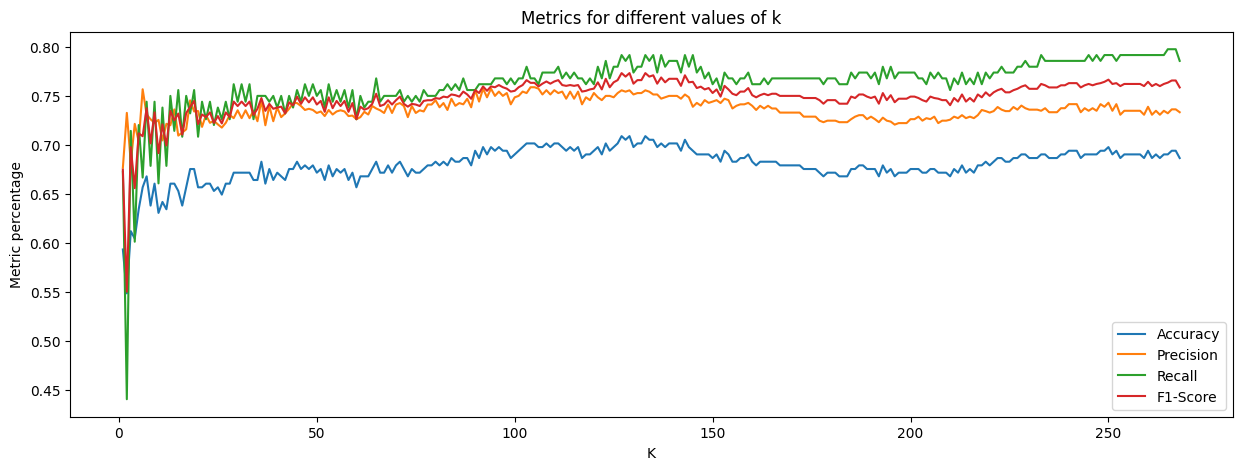

In [127]:
plt.figure(figsize=(15, 5))
plt.title('Metrics for different values of k')
plt.xlabel('K')
plt.ylabel('Metric percentage')
plt.plot(range(1, len(test) + 1), accuracies, label='Accuracy')
plt.plot(range(1, len(test) + 1), precisions, label='Precision')
plt.plot(range(1, len(test) + 1), recalls, label='Recall')
plt.plot(range(1, len(test) + 1), f1_scores, label='F1-Score')
plt.legend()
plt.show()

In [159]:
accuracies = []
precisions = []
recalls = []
f1_scores = []
k_values = [2, 10, 50]

for k in k_values:
    print(f'========================== \n\nK = {k}\n')
    classification = classify_knn(k, train_X, test_X, train_y)
    accuracy, precision, recall, f1_score = obtain_metrics(classification, test_y)
    print(f"Accuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall},\nF1-Score: {f1_score}", end='\n\n')
    
    print(f"Confusion Matrix: \n{confusion_matrix(classification, test_y)}", end='\n\n')



K = 2

Accuracy: 0.5485074626865671,
Precision: 0.7326732673267327,
Recall: 0.44047619047619047,
F1-Score: 0.550185873605948

Confusion Matrix: 
                 Target 5 Yrs(+)  Target 5 Yrs(-)
Target 5 Yrs(+)               74               94
Target 5 Yrs(-)               27               73


K = 10

Accuracy: 0.6305970149253731,
Precision: 0.7254901960784313,
Recall: 0.6607142857142857,
F1-Score: 0.6915887850467289

Confusion Matrix: 
                 Target 5 Yrs(+)  Target 5 Yrs(-)
Target 5 Yrs(+)              111               57
Target 5 Yrs(-)               42               58


K = 50

Accuracy: 0.6716417910447762,
Precision: 0.7325581395348837,
Recall: 0.75,
F1-Score: 0.7411764705882353

Confusion Matrix: 
                 Target 5 Yrs(+)  Target 5 Yrs(-)
Target 5 Yrs(+)              126               42
Target 5 Yrs(-)               46               54

